# Modeling and Simulation in Python

Chapter 18

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

Read the data.

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [3]:
I = interpolate(data.insulin)

Initialize the parameters

In [4]:
G0 = 290
k1 = 0.03
k2 = 0.02
k3 = 1e-05

1e-05

To estimate basal levels, we'll use the concentrations at `t=0`.

In [5]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

Create the initial condtions.

In [6]:
init = State(G=G0, X=0)

,values
G,290
X,0


Make the `System` object.

In [7]:
t_0 = get_first_label(data)
t_end = get_last_label(data)

182

In [8]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                t_0=t_0, t_end=t_end, dt=2)

,values
init,G 290 X 0 dtype: int64
k1,0.03
k2,0.02
k3,1e-05
I,<scipy.interpolate.interpolate.interp1d object...
Gb,92
Ib,11
t_0,0
t_end,182
dt,2


In [9]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [10]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [11]:
%time results = run_simulation(system, update_func);

Wall time: 425 ms


### Numerical solution

In the previous chapter, we approximated the differential equations with difference equations, and solved them using `run_simulation`.

In this chapter, we solve the differential equation numerically using `run_ode_solver`, which is a wrapper for the SciPy ODE solver.

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.  We don't have to do the update part; the solver does it for us.

In [12]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [13]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [14]:
%time results2, details = run_ode_solver(system, slope_func, t_eval=data.index);

Wall time: 70.8 ms


`details` is a `ModSimSeries` object with information about how the solver worked.

In [15]:
details

,values
sol,None
t_events,[]
nfev,80
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [16]:
results2

,G,X
0,290.000000,0.000000
2,278.441931,0.000148
4,267.162253,0.001767
6,255.552173,0.003811
8,243.778869,0.004825
10,232.556562,0.005397
12,221.879405,0.005891
14,211.755465,0.006272
16,202.205389,0.006538
19,188.978971,0.006786


Plotting the results from `run_simulation` and `run_ode_solver`, we can see that they are not very different.

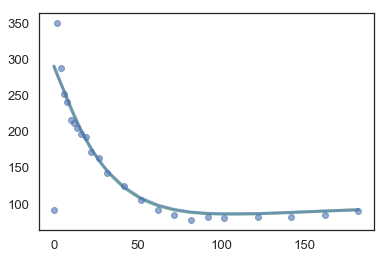

In [17]:
plot(results.G, 'g-')
plot(results2.G, 'b-')
plot(data.glucose, 'bo')

The differences in `G` are less than 1%.

In [18]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.dropna()

0              0
2      -0.115619
4     -0.0783993
6       0.290855
8        0.52969
10      0.579892
12       0.59593
14      0.580565
16      0.535504
22      0.282925
32     -0.122467
42     -0.454298
52     -0.734567
62     -0.798479
72     -0.700541
82     -0.499145
92     -0.458979
102    -0.350362
122    -0.155287
142   -0.0781028
162    0.0185836
182    0.0544144
Name: G, dtype: object

### Optimization

Now let's find the parameters that yield the best fit for the data.  

We'll use these values as an initial estimate and iteratively improve them.

In [19]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


`make_system` takes the parameters and actual data and returns a `System` object.

In [20]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib,
                  t_0=t_0, t_end=t_end)

In [21]:
system = make_system(params, data)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290.0 X 0.0 dtype: float64
Gb,92
Ib,11
t_0,0
t_end,182


`error_func` takes the parameters and actual data, makes a `System` object, and runs `odeint`, then compares the results to the data.  It returns an array of errors.

In [22]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_ode_solver(system, slope_func, t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors

When we call `error_func`, we provide a sequence of parameters as a single object.

Here's how that works:

In [23]:
error_func(params, data)

G0    290.00000
k1      0.03000
k2      0.02000
k3      0.00001
dtype: float64


0      198.000000
2      -71.558069
4      -19.837747
6        4.552173
8        3.778869
10      16.556562
12      10.879405
14       6.755465
16       6.205389
19      -3.021029
22       5.025756
27      -3.328046
32       3.140578
42      -1.100002
52       2.928112
62       6.230846
72       8.105344
82      11.467763
92       4.717777
102      5.066338
122      4.391387
142      6.078120
162      4.951526
182      1.674908
dtype: float64

`fit_leastsq` is a wrapper for `scipy.optimize.leastsq`

Here's how we call it.

In [24]:
best_params, fit_details = fit_leastsq(error_func, params, data)

[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.90000004e+02 3.00000000e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000004e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000003e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000000e-02 1.00000001e-05]
[ 2.43786323e+02  1.61767200e-02 -6.48609735e-03  7.89127092e-06]
[2.64108612e+02 2.45750702e-02 1.38663695e-02 9.55804438e-06]
[2.64108616e+02 2.45750702e-02 1.38663695e-02 9.55804438e-06]
[2.64108612e+02 2.45750705e-02 1.38663695e-02 9.55804438e-06]
[2.64108612e+02 2.45750702e-02 1.38663697e-02 9.55804438e-06]
[2.64108612e+02 2.45750702e-02 1.38663695e-02 9.55804452e-06]
[2.49160249e+02 1.81928371e-02 9.60755217e-03 9.15038103e-06]
[2.49160253e+02 1.81928371e-02 9.60755217e-03 9.15038103e-06]
[2.49160249e+02 1.81928374e-02 9.60755217e-03 9.15038103e-06]
[2.49160249e+02 1.81928371e-02 9.60755231e-03 9.15038103e-06]
[2.49160249e+02 1.81928371

The first return value is a `Params` object with the best parameters:

In [25]:
best_params

,values
G0,251.944588
k1,0.019761
k2,0.014644
k3,0.000009


The second return value is a `ModSimSeries` object with information about the results.

In [26]:
fit_details

,values
fvec,"[159.944588219575, -104.27659960371093, -47.59..."
nfev,119
fjac,"[[-1992377962.6452265, -4672.587526036756, -31..."
ipvt,"[4, 3, 2, 1]"
qtf,"[-0.0007600741683404522, 3.163622306853597, -2..."
cov_x,"[[0.2634495178644443, 8.200553507149606e-05, -..."
mesg,The relative error between two consecutive ite...
ier,2


In [27]:
fit_details

,values
fvec,"[159.944588219575, -104.27659960371093, -47.59..."
nfev,119
fjac,"[[-1992377962.6452265, -4672.587526036756, -31..."
ipvt,"[4, 3, 2, 1]"
qtf,"[-0.0007600741683404522, 3.163622306853597, -2..."
cov_x,"[[0.2634495178644443, 8.200553507149606e-05, -..."
mesg,The relative error between two consecutive ite...
ier,2


Now that we have `best_params`, we can use it to make a `System` object and run it.

In [28]:
system = make_system(best_params, data)
results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results, along with the data.  The first few points of the model don't fit the data, but we don't expect them to.

Saving figure to file figs/chap08-fig04.pdf


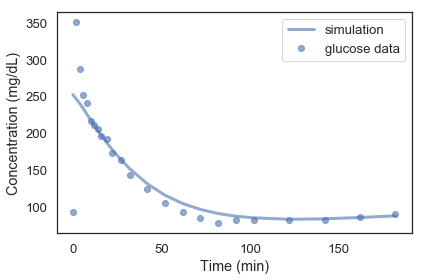

In [29]:
plot(results.G, label='simulation')
plot(data.glucose, 'bo', label='glucose data')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

savefig('figs/chap08-fig04.pdf')

### Interpreting parameters

Based on the parameters of the model, we can estimate glucose effectiveness and insulin sensitivity.

In [30]:
def indices(params):
    """Compute glucose effectiveness and insulin sensitivity.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: State object containing S_G and S_I
    """
    G0, k1, k2, k3 = params
    return State(S_G=k1, S_I=k3/k2)

Here are the results.

In [31]:
indices(best_params)

,values
S_G,0.019761
S_I,0.000648


### Under the hood

Here's the source code for `run_ode_solver` and `fit_leastsq`, if you'd like to know how they work.

In [32]:
%psource run_ode_solver

In [33]:
%psource fit_leastsq

## Exercises

**Exercise:** Since we don't expect the first few points to agree, it's probably better not to make them part of the optimization process.  We can ignore them by leaving them out of the `Series` returned by `error_func`.  Modify the last line of `error_func` to return `errors.loc[8:]`, which includes only the elements of the `Series` from `t=8` and up.

Does that improve the quality of the fit?  Does it change the best parameters by much?

Note: You can read more about this use of `loc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

**Exercise:** How sensitive are the results to the starting guess for the parameters.  If you try different values for the starting guess, do we get the same values for the best parameters?

**Related reading:** You might be interested in this article about [people making a DIY artificial pancreas](https://www.bloomberg.com/news/features/2018-08-08/the-250-biohack-that-s-revolutionizing-life-with-diabetes).

In [34]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_ode_solver(system, slope_func, t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors.loc[8:]

In [40]:
error_func(params, data)
best_params, fit_details = fit_leastsq(error_func, params, data)
best_params

G0    290.00000
k1      0.03000
k2      0.02000
k3      0.00001
dtype: float64
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.90000004e+02 3.00000000e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000004e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000003e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000000e-02 1.00000001e-05]
[2.70041185e+02 2.66989610e-02 3.09636831e-03 8.45262743e-06]
[2.70041189e+02 2.66989610e-02 3.09636831e-03 8.45262743e-06]
[2.70041185e+02 2.66989614e-02 3.09636831e-03 8.45262743e-06]
[2.70041185e+02 2.66989610e-02 3.09636836e-03 8.45262743e-06]
[2.70041185e+02 2.66989610e-02 3.09636831e-03 8.45262756e-06]
[2.71996449e+02 2.79863791e-02 3.93029960e-03 8.43585772e-06]
[2.71996453e+02 2.79863791e-02 3.93029960e-03 8.43585772e-06]
[2.71996449e+02 2.79863796e-02 3.93029960e-03 8.43585772e-06]
[2.71996449e+02 2.79863791e-02 3.93029966e-03 8.43585772e-06]
[2.71996449e+

,values
G0,276.023766
k1,0.029776
k2,0.008500
k3,0.000008


In [41]:
fit_details

,values
fvec,"[-5.759126528561325, 8.21147789422514, 3.60064..."
nfev,94
fjac,"[[6245307.42232215, 0.9839178323942438, -0.459..."
ipvt,"[4, 2, 3, 1]"
qtf,"[-0.7744962989830633, 1.0367859290170998, 2.92..."
cov_x,"[[5.754065662068523, 0.0033437225509999864, -0..."
mesg,The relative error between two consecutive ite...
ier,2


In [42]:
system = make_system(best_params, data)
results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Saving figure to file figs/chap08-fig04.pdf


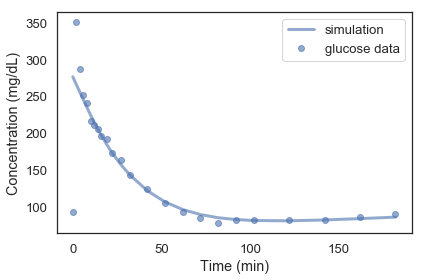

In [43]:
plot(results.G, label='simulation')
plot(data.glucose, 'bo', label='glucose data')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

savefig('figs/chap08-fig04.pdf')

In [44]:
def indices(params):
    """Compute glucose effectiveness and insulin sensitivity.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: State object containing S_G and S_I
    """
    G0, k1, k2, k3 = params
    return State(S_G=k1, S_I=k3/k2)

In [45]:
indices(best_params)

,values
S_G,0.029776
S_I,0.000995
